# Code lab for Skripsi (Refined)

This branch implements the real world scenario of feature selection-train-cross validate-test sequence, so that the validation data does not get leaked by the feature selection method.

Feature extraction part is done in `deep_feature_extractior.ipynb` files. This file is used to feature selection and train model

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

import joblib

In [2]:
df = pd.read_parquet('data/resnet50_img_feature_224_globalavgpool.parquet')

In [3]:
file_name = df.pop('file_name')
label = df.pop('is_infected')

In [4]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

## Hyperparameter tuning with Cross Validation

Find Hyperparameter C with cross validation and will be using k=10. Metrics being used is F1-Score, Recall, Precision, and Accuracy.

### With Feature Selection

In [5]:
svc_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
METRICS = ['f1', 'recall', 'precision', 'accuracy']
cv_results = []

for c in svc_C:
    svm = SVC(kernel='linear', C=c, random_state=42)
    selector = SelectFromModel(svm)
    pipeline = make_pipeline(selector, svm)
    # pipeline.fit(X_train, y_train)
    cv_result = cross_validate(pipeline, X_train, y_train, cv=5, scoring=METRICS)
    cv_results.append(cv_result)
    print('C =', c)
    # print('Threshold :', pipeline['selectfrommodel'].threshold_)
    # print('No. selected feature :', pipeline['selectfrommodel'].get_feature_names_out().shape)
    # print('Accuracy :', pipeline.score(X_test, y_test))
    print('-------------------------\n')

C = 0.001
-------------------------
C = 0.01
-------------------------
C = 0.1
-------------------------
C = 1
-------------------------
C = 10
-------------------------
C = 100
-------------------------
C = 1000
-------------------------


In [6]:
results_array = []
for i in range(len(cv_results)):
    results_array.append(np.concatenate(list(cv_results[i].values())))
results_array = np.vstack(results_array)

columns_list = [f'split{i}_{x}' for x in cv_results[0].keys() for i in range(5)]
cv_results_df = pd.DataFrame(results_array,
                             columns=columns_list)
cv_results_df

,split0_fit_time,split1_fit_time,split2_fit_time,split3_fit_time,split4_fit_time,split0_score_time,split1_score_time,split2_score_time,split3_score_time,split4_score_time,...,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy
0,0.846998,0.711000,0.750999,0.826000,0.697999,0.035001,0.037,0.036999,0.038000,0.035,...,0.816092,0.819355,0.826087,0.817647,0.857143,0.840625,0.809375,0.828125,0.837500,0.843750
1,0.724000,0.641000,0.636000,0.628000,0.821000,0.034999,0.033,0.034000,0.033000,0.038,...,0.829268,0.834395,0.829412,0.839286,0.881119,0.834375,0.828125,0.850000,0.856250,0.840625
2,0.778000,0.683001,0.690999,0.672000,0.674000,0.028000,0.033,0.030000,0.029999,0.031,...,0.832298,0.830065,0.792683,0.826087,0.836601,0.831250,0.815625,0.800000,0.828125,0.821875
3,0.984000,0.683000,0.688000,0.709001,0.660000,0.030000,0.030,0.031000,0.031002,0.030,...,0.830303,0.836601,0.792683,0.822086,0.846667,0.837500,0.821875,0.800000,0.828125,0.825000
4,0.765000,0.754000,0.696001,0.685000,0.677000,0.031000,0.031,0.030998,0.031000,0.030,...,0.830303,0.836601,0.792683,0.822086,0.846667,0.837500,0.821875,0.800000,0.828125,0.825000
5,0.791000,0.695000,0.789000,0.685000,0.673000,0.030000,0.043,0.030000,0.033000,0.031,...,0.830303,0.836601,0.792683,0.822086,0.846667,0.837500,0.821875,0.800000,0.828125,0.825000
6,0.719000,0.682000,0.696000,0.715998,0.732000,0.029000,0.029,0.040002,0.031000,0.032,...,0.830303,0.836601,0.792683,0.822086,0.846667,0.837500,0.821875,0.800000,0.828125,0.825000


In [7]:
cv_results_df.insert(0, 'C', svc_C)
cv_results_df['mean_fit_time'] = cv_results_df[['split0_fit_time', 'split1_fit_time', 'split2_fit_time', 'split3_fit_time', 'split4_fit_time']].mean(axis=1)
cv_results_df['mean_score_time'] = cv_results_df[['split0_score_time', 'split1_score_time', 'split2_score_time', 'split3_score_time', 'split4_score_time']].mean(axis=1)
cv_results_df['mean_test_f1'] = cv_results_df[['split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1']].mean(axis=1)
cv_results_df['mean_test_recall'] = cv_results_df[['split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall']].mean(axis=1)
cv_results_df['mean_test_precision'] = cv_results_df[['split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision']].mean(axis=1)
cv_results_df['mean_test_accuracy'] = cv_results_df[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy']].mean(axis=1)
cv_results_df

,C,split0_fit_time,split1_fit_time,split2_fit_time,split3_fit_time,split4_fit_time,split0_score_time,split1_score_time,split2_score_time,split3_score_time,...,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_fit_time,mean_score_time,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
0,0.001,0.846998,0.711000,0.750999,0.826000,0.697999,0.035001,0.037,0.036999,0.038000,...,0.809375,0.828125,0.837500,0.843750,0.766599,0.0364,0.833192,0.840148,0.827265,0.831875
1,0.010,0.724000,0.641000,0.636000,0.628000,0.821000,0.034999,0.033,0.034000,0.033000,...,0.828125,0.850000,0.856250,0.840625,0.690000,0.0346,0.841881,0.842694,0.842696,0.841875
2,0.100,0.778000,0.683001,0.690999,0.672000,0.674000,0.028000,0.033,0.030000,0.029999,...,0.815625,0.800000,0.828125,0.821875,0.699600,0.0304,0.818564,0.813960,0.823547,0.819375
3,1.000,0.984000,0.683000,0.688000,0.709001,0.660000,0.030000,0.030,0.031000,0.031002,...,0.821875,0.800000,0.828125,0.825000,0.744800,0.0304,0.821986,0.818936,0.825668,0.822500
4,10.000,0.765000,0.754000,0.696001,0.685000,0.677000,0.031000,0.031,0.030998,0.031000,...,0.821875,0.800000,0.828125,0.825000,0.715400,0.0308,0.821986,0.818936,0.825668,0.822500
5,100.000,0.791000,0.695000,0.789000,0.685000,0.673000,0.030000,0.043,0.030000,0.033000,...,0.821875,0.800000,0.828125,0.825000,0.726600,0.0334,0.821986,0.818936,0.825668,0.822500
6,1000.000,0.719000,0.682000,0.696000,0.715998,0.732000,0.029000,0.029,0.040002,0.031000,...,0.821875,0.800000,0.828125,0.825000,0.709000,0.0322,0.821986,0.818936,0.825668,0.822500


In [10]:
cv_results_df.to_csv(r'result\cv_results_fs_224_globalavgpool.tsv', sep='\t', index=False)
cv_results_df[['C', 'mean_fit_time', 'mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy']]

,C,mean_fit_time,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
0,0.001,0.766599,0.833192,0.840148,0.827265,0.831875
1,0.010,0.690000,0.841881,0.842694,0.842696,0.841875
2,0.100,0.699600,0.818564,0.813960,0.823547,0.819375
3,1.000,0.744800,0.821986,0.818936,0.825668,0.822500
4,10.000,0.715400,0.821986,0.818936,0.825668,0.822500
5,100.000,0.726600,0.821986,0.818936,0.825668,0.822500
6,1000.000,0.709000,0.821986,0.818936,0.825668,0.822500


In [9]:
X_train.shape

(1600, 100352)

#### With Different Threshold

In [11]:
PARAM_GRID = {
    'selectfrommodel__threshold': ['median', 'mean'],
    'svc__C': svc_C
}

grid = GridSearchCV(
    make_pipeline(SelectFromModel(SVC(kernel='linear', random_state=42)),
                  SVC(kernel='linear', random_state=42)),
    cv=5,
    param_grid=PARAM_GRID,
    scoring=METRICS,
    refit=False,
    verbose=3,
    n_jobs=3
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectfrommodel',
                                        SelectFromModel(estimator=SVC(kernel='linear',
                                                                      random_state=42))),
                                       ('svc',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             n_jobs=3,
             param_grid={'selectfrommodel__threshold': ['median', 'mean'],
                         'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit=False, scoring=['f1', 'recall', 'precision', 'accuracy'],
             verbose=3)

In [12]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectfrommodel__threshold,param_svc__C,params,split0_test_f1,split1_test_f1,split2_test_f1,...,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,2.750599,0.395061,0.064400,0.003200,median,0.001,"{'selectfrommodel__threshold': 'median', 'svc_...",0.856269,0.826498,0.841121,...,0.016446,3,0.853125,0.828125,0.840625,0.815625,0.834375,0.834375,0.012500,3
1,2.157400,0.055941,0.046599,0.005085,median,0.01,"{'selectfrommodel__threshold': 'median', 'svc_...",0.861446,0.814103,0.844985,...,0.014269,2,0.856250,0.818750,0.840625,0.843750,0.828125,0.837500,0.012960,2
2,2.264797,0.119672,0.042200,0.002929,median,0.1,"{'selectfrommodel__threshold': 'median', 'svc_...",0.839506,0.806349,0.827160,...,0.009829,13,0.837500,0.809375,0.825000,0.825000,0.812500,0.821875,0.010078,13
3,2.217400,0.015630,0.046799,0.006644,median,1,"{'selectfrommodel__threshold': 'median', 'svc_...",0.839506,0.803797,0.827160,...,0.011006,4,0.837500,0.806250,0.825000,0.831250,0.815625,0.823125,0.011110,5
4,2.109402,0.039688,0.039999,0.002367,median,10,"{'selectfrommodel__threshold': 'median', 'svc_...",0.839506,0.803797,0.827160,...,0.011006,4,0.837500,0.806250,0.825000,0.831250,0.815625,0.823125,0.011110,5
5,2.152598,0.041989,0.040600,0.001497,median,100,"{'selectfrommodel__threshold': 'median', 'svc_...",0.839506,0.803797,0.827160,...,0.011006,4,0.837500,0.806250,0.825000,0.831250,0.815625,0.823125,0.011110,5
6,2.211601,0.036436,0.037200,0.000398,median,1000,"{'selectfrommodel__threshold': 'median', 'svc_...",0.839506,0.803797,0.827160,...,0.011006,4,0.837500,0.806250,0.825000,0.831250,0.815625,0.823125,0.011110,5
7,2.123399,0.076112,0.053999,0.006603,mean,0.001,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.843373,0.825000,0.832298,...,0.013567,12,0.837500,0.825000,0.831250,0.818750,0.831250,0.828750,0.006374,4
8,2.070199,0.077702,0.041401,0.003555,mean,0.01,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.866667,0.822430,0.837920,...,0.016030,1,0.862500,0.821875,0.834375,0.843750,0.828125,0.838125,0.014170,1
9,2.169801,0.016679,0.034800,0.001600,mean,0.1,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.841463,0.815287,0.802469,...,0.015800,14,0.837500,0.818750,0.800000,0.831250,0.821875,0.821875,0.012809,13


### Without Feature Selection

In [ ]:
PARAM_GRID = {'C': svc_C}

grid_no_fs = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    cv=5,
    param_grid=PARAM_GRID,
    scoring=METRICS,
    refit=False,
    verbose=3
)
grid_no_fs.fit(X_train, y_train)

In [40]:
cv_result_no_fs = pd.DataFrame(grid_no_fs.cv_results_)
cv_result_no_fs.to_csv(r'result\cv_result_no_fs.tsv', sep='\t', index=False)
cv_result_no_fs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,88.802842,0.944986,16.622678,0.262505,0.001,{'C': 0.001},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
1,86.668458,0.498128,16.472115,0.216653,0.01,{'C': 0.01},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
2,85.676329,0.682434,16.501517,0.196086,0.1,{'C': 0.1},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
3,88.654822,2.457385,16.551476,0.416479,1,{'C': 1},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
4,88.119997,1.343442,17.029122,0.641395,10,{'C': 10},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
5,88.769875,2.984865,16.633774,0.619866,100,{'C': 100},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
6,84.894957,1.007263,16.099048,0.207735,1000,{'C': 1000},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1


In [41]:
cv_result_no_fs[['param_C', 'mean_fit_time', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]

,param_C,mean_fit_time,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_accuracy
0,0.001,88.802842,0.815064,0.827872,0.803983,0.8175
1,0.01,86.668458,0.815064,0.827872,0.803983,0.8175
2,0.1,85.676329,0.815064,0.827872,0.803983,0.8175
3,1,88.654822,0.815064,0.827872,0.803983,0.8175
4,10,88.119997,0.815064,0.827872,0.803983,0.8175
5,100,88.769875,0.815064,0.827872,0.803983,0.8175
6,1000,84.894957,0.815064,0.827872,0.803983,0.8175


## Build and run the model

Because all metrics are the same on all C, we train it using the C that provide the least fit time, that is C=0.1

In [13]:
best_param_svm = SVC(kernel="linear", C=0.01, random_state=42)
best_selector = SelectFromModel(best_param_svm)
new_pipeline = make_pipeline(best_selector,
                             best_param_svm)
new_pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=SVC(C=0.01, kernel='linear',
                                               random_state=42))),
                ('svc', SVC(C=0.01, kernel='linear', random_state=42))])

In [14]:
joblib.dump(new_pipeline, r'dumps\pipeline_224_globalavgpool.joblib')

['dumps\\pipeline_224_globalavgpool.joblib']

### Calculate Threshold Manually

Train SVM on all X_train to calculate the threshold manually

In [15]:
train_svm = SVC(kernel='linear', C=0.01)
train_svm.fit(X_train, y_train)

SVC(C=0.01, kernel='linear')

In [21]:
np.savetxt(r'data\svm_coef_224_globalavgpool.txt', train_svm.coef_, delimiter='\n')

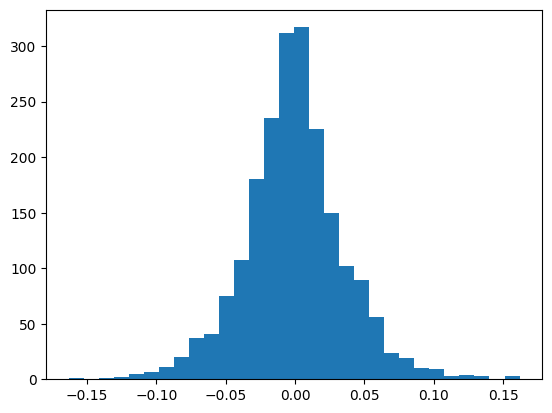

In [22]:
coef = np.loadtxt(r'data\svm_coef_224_globalavgpool.txt')
plt.hist(coef, bins=30)
plt.show()

(array([78., 83., 91., 86., 83., 75., 76., 81., 78., 82.]),
 array([1.0000e+00, 2.0550e+02, 4.1000e+02, 6.1450e+02, 8.1900e+02,
        1.0235e+03, 1.2280e+03, 1.4325e+03, 1.6370e+03, 1.8415e+03,
        2.0460e+03]),
 <BarContainer object of 10 artists>)

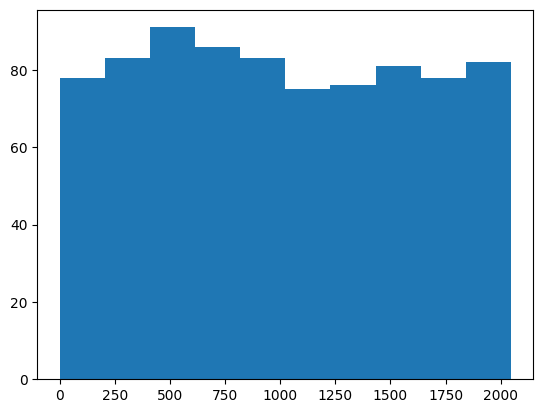

In [23]:
plt.hist(np.where(np.abs(coef) > np.abs(coef).mean())[0])

In [24]:
print('Threshold:', np.abs(train_svm.coef_).mean())

Threshold: 0.026783355159533215


### Get Selector and Estimator Properties

In [25]:
print('Threshold :', new_pipeline['selectfrommodel'].threshold_)

Threshold : 0.026783355159533215


In [26]:
print('No. selected feature :', new_pipeline['selectfrommodel'].get_feature_names_out().shape)

No. selected feature : (813,)


In [27]:
np.savetxt(r'data\svm_coef_selected_224_globalavgpool.txt', new_pipeline['svc'].coef_, delimiter='\n')

## Evaluate Model

Evaluate model on test data using same metrics from cross-validation.

In [5]:
new_pipeline = joblib.load(r'dumps\pipeline_224_globalavgpool.joblib')

In [28]:
y_pred = new_pipeline.predict(X_test)
true_pred_df = pd.DataFrame({'file_name': file_name[X_test.index],
                             'y_true': np.where(y_test == 0, 'normal', 'terinfeksi'),
                             'y_pred': np.where(y_pred == 0, 'normal', 'terinfeksi')})
true_pred_df.to_csv(r'result\true_pred_224_globalavgpool.csv', index=False)
true_pred_df

,file_name,y_true,y_pred
1860,DSC04798_4.JPG,normal,normal
353,DSC04353_4.JPG,terinfeksi,terinfeksi
1333,DSC04273_8.JPG,normal,normal
905,DSC04721_6.JPG,terinfeksi,terinfeksi
1289,DSC04254_9.JPG,normal,normal
...,...,...,...
965,DSC04793_5.JPG,terinfeksi,terinfeksi
1284,DSC04253_7.JPG,normal,normal
1739,DSC04633_1.JPG,normal,normal
261,DSC04249_9.JPG,terinfeksi,terinfeksi


[[174  27]
 [ 31 168]]


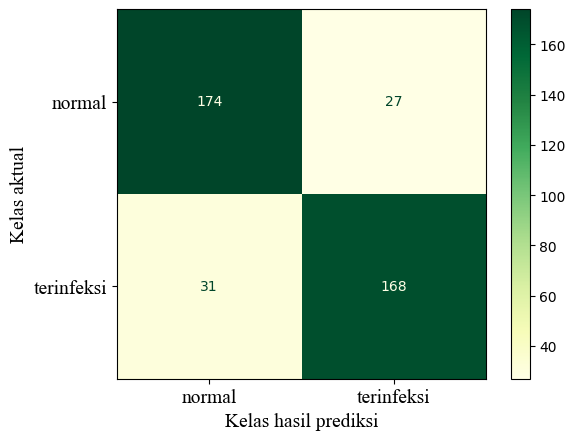

In [4]:
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['normal', 'terinfeksi'],
    cmap='YlGn'
)

tnrfont = {'fontname':'Times New Roman', 'fontsize': 14}

plt.xlabel('Kelas hasil prediksi', **tnrfont)
plt.ylabel('Kelas aktual', **tnrfont)
plt.xticks(**tnrfont)
plt.yticks(**tnrfont)
plt.show()

In [30]:
metrics_list = [metrics.f1_score,
                metrics.accuracy_score,
                metrics.precision_score,
                metrics.recall_score]

for metric in metrics_list:
    print(metric.__name__ + ':', metric(y_test, y_pred))

f1_score: 0.8527918781725888
accuracy_score: 0.855
precision_score: 0.8615384615384616
recall_score: 0.8442211055276382
